In [20]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import math
from selenium import webdriver
from selenium.webdriver.support.ui import Select
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.common.by import By
import time
from io import StringIO
from selenium.webdriver.support import expected_conditions as EC

webdriver_path = r'C:\Users\kevin\Downloads\chromedriver-win64\chromedriver-win64\chromedriver.exe'

try:
    # Set Chrome executable path and options
    options = Options()
    options.headless = True
    driver = webdriver.Chrome(options)
    driver.maximize_window()

    #Quick little scrape of full premier league table   
    url = 'https://www.premierleague.com/tables'
    driver.get(url)

    WebDriverWait(driver, 10).until(
        EC.presence_of_element_located((By.XPATH, '//*[@id="onetrust-accept-btn-handler"]'))
    )

    # Click the 'Accept All Cookies' button
    accept_cookies_button = driver.find_element(By.XPATH, '//*[@id="onetrust-accept-btn-handler"]')
    accept_cookies_button.click()

    #waits for table to load in
    WebDriverWait(driver, 10).until(
        EC.presence_of_element_located((By.XPATH, '//*[@id="mainContent"]/div[3]/div[1]/div[5]/div/div/div/table'))
    )
    
    prem_table = driver.find_element(By.XPATH, '//*[@id="mainContent"]/div[3]/div[1]/div[5]/div/div/div/table') #does this twice to acess table and make sure its not stale request
    prem_table = driver.find_element(By.XPATH, '//*[@id="mainContent"]/div[3]/div[1]/div[5]/div/div/div/table')
    prem_table_html = prem_table.get_attribute('outerHTML')
    soup = BeautifulSoup(prem_table_html, 'html.parser')
    teams = soup.find_all('tr') #finds all rows in table

    team_rows = []
    for team in teams:
        team_row = [td.get_text(strip=True) for td in team.find_all(['td', 'th'])] #finds all the td and th elements in the current tr html element and iterates through and gets the text
        team_rows.append(team_row)

    table_df = pd.DataFrame(team_rows, columns=["Position", "Club", "GamesPlayed", "Won", "Drawn", "Lost", "GoalsFor", "GoalsAgainst", "GoalDifferential", "Points", "Form", "Next", "More"])
    table_df = table_df.iloc[1:] #removes first row which contains labels(I already made them)
    clubs = table_df['Club']
    clubs = [club for club in clubs if club is not None] #removes all None from list
    clubs = [club[:-3] for club in clubs] #removes last 3 letters of each club(the dumb LIV or CHE at end)

    #this section makes sure there is no difference in naming conventions for scraping between the two websites tables
    replacements = {
        'Brighton and Hove Albion': 'Brighton',
        'Nottingham Forest': 'Nott\'m Forest',
        'Manchester City': 'Man City',
        'Manchester United': 'Man Utd',
        'West Ham United': 'West Ham',
        'Wolverhampton Wanderers': 'Wolves',
        'Tottenham Hotspur': 'Spurs',
        'Sheffield United': 'Sheffield Utd',
        'Luton Town': 'Luton',
        'Newcastle United': 'Newcastle',
    }
    clubs = [replacements.get(x, x) for x in clubs]
    print(clubs)

    games_played = table_df['GamesPlayed'] #gets gamesplayed column into an array that matches up with team name
    games_played = [club for club in games_played if club is not None] #removes all None from list of games_played
    games_played = [int(x) for x in games_played] #converts from string to int for each value in array
    

    
    # Main scraping of fpl stats
    url = 'https://fantasy.premierleague.com/statistics'
    driver.get(url)
    
    #gets select variable that selects sorted view drop down menu
    sorted_element = driver.find_element(By.XPATH, '//*[@id="sort"]')
    select_sort = Select(sorted_element)
    select_sort.select_by_value('minutes')
    
    #gets select variable that selects filter view drop down menu
    dropdown_element = driver.find_element(By.XPATH, '//*[@id="filter"]')
    select = Select(dropdown_element)

    total_team_costs = []
    total_team_points = []
    total_team_ROIs = []
    total_consistent_players = []
    team_names = []

    data_frame = pd.DataFrame(columns=["Status", "Player", "Cost", "Selected", "Form", "Points", "Minutes", "ROI"])

    for i in range(1,21):
        option_text = f"te_{i}" #each labeled te_1 or te_2 so Im doing it for each of the 20 teams
        select.select_by_value(option_text)

        #gets team name from selected drop down
        selected_option = select.first_selected_option
        selected_text = selected_option.text

        #matches the team name to index of scraping prem table earlier. Then gets that indexed value from games_played to perform calculations on that teams expected minutes
        team_index = clubs.index(selected_text)
        matches_played = games_played[team_index]
        expected_minutes = math.floor(matches_played * 90 * .4)
        
        table = driver.find_element(By.XPATH, '//*[@id="root"]/div[2]/div/div[1]/table')
        table_html = table.get_attribute('outerHTML') # Get the HTML content of the element
        
        soup = BeautifulSoup(table_html, 'html.parser')
        players = soup.find_all('tr')

        rows = []
        for player in players:
            row = [td.get_text(strip=True) for td in player.find_all(['td', 'th'])] #finds all the td and th elements in the current tr html element and iterates through and gets the text
            rows.append(row)

        df = pd.DataFrame(rows, columns=["Status", "Player", "Cost", "Selected", "Form", "Points", "Minutes"])
        df = df.iloc[1:] #removes first row which contains labels(I already made them)
        df = df[df['Points'] != 0] #removes every player with 0 fantasy points
        df['ROI'] = pd.to_numeric(df['Points']) / pd.to_numeric(df['Cost']) #makes a new ROI column based off of the existing points and cost columns
        #print(df)

        #this section adds eligible players from this team who meet minutes requirement to the overall data_frame
        regular_player_count = len(df[pd.to_numeric(df['Minutes']) >= expected_minutes]) #gets the rows that have minutes column greater than or equal to expected_minutes and gets length
        regular_player_df = df[pd.to_numeric(df['Minutes']) >= expected_minutes]
        # Drop empty or all-NA columns in the empty_df
        data_frame = data_frame.dropna(axis=1, how='all')
        data_frame = pd.concat([data_frame, regular_player_df], ignore_index=True)  # ignore_index=True resets index

        total_team_costs.append(round(pd.to_numeric(df['Cost']).sum(), 1)) #sums up cost column and appends it to total team costs
        total_team_points.append(pd.to_numeric(df['Points']).sum()) #sums up points column and appends it to total team costs
        total_team_ROIs.append(round(df['ROI'].sum() / len(df), 2)) #sums up ROI column and divides it by number of players to get average ROI and appends it to total team ROIs
        total_consistent_players.append(regular_player_count)
        team_names.append(selected_text)
        
        #time.sleep(1)
    
    # Close the browser window
    
    driver.quit()

    #stats based on the huge dataframe with all fpl players who meet the minimum minutes requirement
    average_roi = data_frame['ROI'].mean()
    # Get the indices of the top 20 largest values in 'ROI' column
    top_50_indices = data_frame['ROI'].nlargest(50).index
    top_50_roi = data_frame['ROI'].nlargest(50).round(2).astype(float).values
    top_50_roi_strings = [f'{value:.2f}' for value in top_50_roi]
    top_50_names = data_frame.loc[top_50_indices]['Player'].values.astype(str)
    top_50_status = data_frame.loc[top_50_indices]['Status'].values.astype(str)
    # Get the indices of the top 20 smallest values in 'ROI' column
    bottom_50_indices = data_frame['ROI'].nsmallest(50).index
    bottom_50_names = data_frame.loc[bottom_50_indices]['Player'].values.astype(str)
    bottom_50_roi = data_frame['ROI'].nsmallest(50).round(2).astype(float).values
    bottom_50_roi_strings = [f'{value:.2f}' for value in bottom_50_roi]

    #gets the top 15 players solely based off points
    top_15_points_indices = pd.to_numeric(data_frame['Points']).nlargest(15).index
    top_15_points = pd.to_numeric(data_frame['Points']).nlargest(15).astype(int).values
    top_15_points_names = data_frame.loc[top_15_points_indices]['Player'].values.astype(str)
    top_15_points_status = data_frame.loc[top_15_points_indices]['Status'].values.astype(str)
    
    print(total_team_costs)
    print(total_team_points)
    print(total_team_ROIs)
    print(total_consistent_players)
    print(team_names)
    print(round(average_roi, 2))
    print(top_50_names)
    print(top_50_status)
    print(top_50_roi_strings)
    print(bottom_50_names)
    print(bottom_50_roi_strings)
    print(top_15_points_names)
    print(top_15_points_status)

except Exception as e:
    print(f"An error occurred: {str(e)}")

['Liverpool', 'Aston Villa', 'Man City', 'Arsenal', 'Spurs', 'West Ham', 'Brighton', 'Man Utd', 'Newcastle', 'Chelsea', 'Wolves', 'Bournemouth', 'Fulham', 'Crystal Palace', "Nott'm Forest", 'Brentford', 'Everton', 'Luton', 'Burnley', 'Sheffield Utd']
[161.4, 149.4, 140.4, 140.0, 145.5, 137.5, 151.2, 138.2, 140.0, 140.3, 166.0, 132.5, 171.1, 156.5, 151.7, 139.0, 134.7, 154.4, 148.3, 138.4]
[986, 924, 768, 727, 786, 632, 823, 748, 759, 805, 1026, 620, 941, 793, 944, 725, 498, 950, 862, 783]
[5.47, 5.58, 5.17, 4.83, 5.07, 4.5, 5.19, 5.07, 5.23, 5.52, 5.15, 4.53, 5.05, 5.02, 5.79, 5.03, 3.64, 5.47, 5.42, 5.32]
[12, 12, 13, 14, 11, 14, 12, 14, 13, 15, 13, 15, 14, 13, 12, 14, 12, 15, 12, 11]
['Arsenal', 'Aston Villa', 'Bournemouth', 'Brentford', 'Brighton', 'Burnley', 'Chelsea', 'Crystal Palace', 'Everton', 'Fulham', 'Liverpool', 'Luton', 'Man City', 'Man Utd', 'Newcastle', "Nott'm Forest", 'Sheffield Utd', 'Spurs', 'West Ham', 'Wolves']
9.31
['AreolaWHUGKP' 'Hee ChanWOLMID' 'Douglas LuizAVL

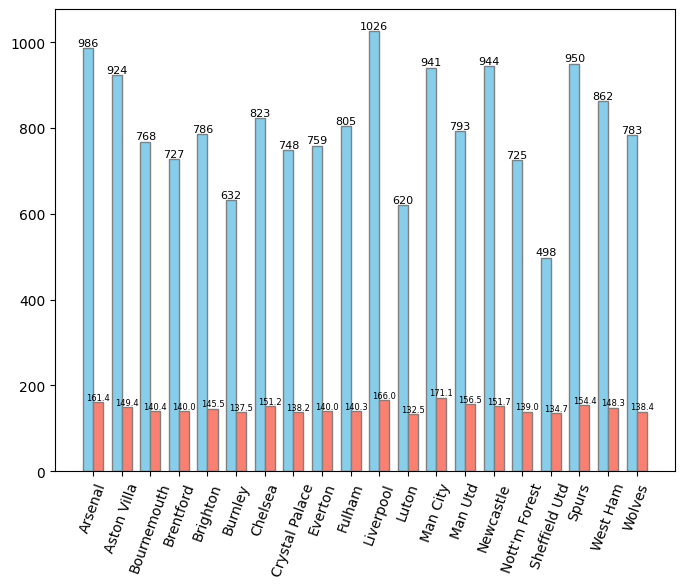

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Define the width of each bar
bar_width = 0.35
index = range(len(team_names))

# Create positions for the bars
r1 = np.arange(len(team_names))  # Positions for the first set of bars
r2 = [x + bar_width for x in r1]  # Positions for the second set of bars

# Create a grouped bar chart
plt.figure(figsize=(8, 6))

# Displaying the values on top of each bar
for i in index:
    plt.text(i, total_team_points[i] + 0.5, str(total_team_points[i]), ha='center', va='bottom', fontsize=8)
    plt.text(i + bar_width, total_team_costs[i] + 0.5, str(total_team_costs[i]), ha='center', va='bottom', fontsize=6)

plt.bar(r1, total_team_points, color='skyblue', width=bar_width, edgecolor='grey', label='Total Fantasy Points')
plt.bar(r2, total_team_costs, color='salmon', width=bar_width, edgecolor='grey', label='Total Squad Costs')

plt.xticks([r + bar_width / 2 for r in range(len(team_names))], team_names)
plt.xticks(rotation=70)

plt.show() 

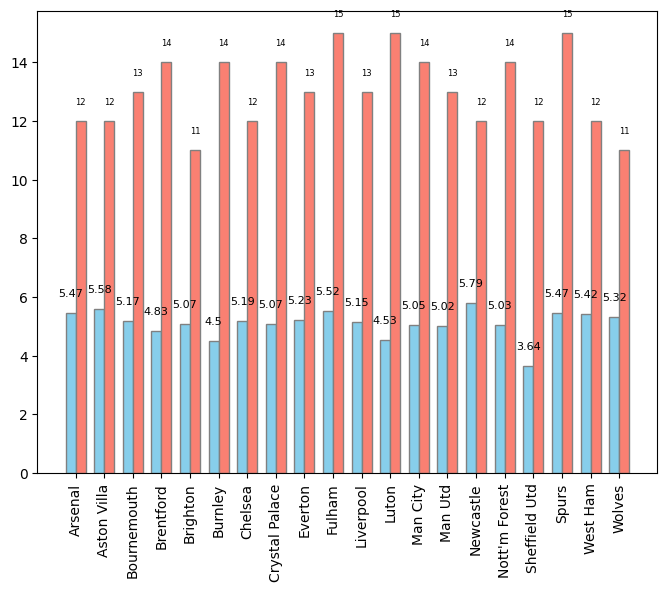

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Define the width of each bar
bar_width = 0.35
index = range(len(team_names))

# Create positions for the bars
r1 = np.arange(len(team_names))  # Positions for the first set of bars
r2 = [x + bar_width for x in r1]  # Positions for the second set of bars

# Create a grouped bar chart
plt.figure(figsize=(8, 6))

# Displaying the values on top of each bar
for i in index:
    plt.text(i, total_team_ROIs[i] + 0.5, str(total_team_ROIs[i]), ha='center', va='bottom', fontsize=8)
    plt.text(i + bar_width, total_consistent_players[i] + 0.5, str(total_consistent_players[i]), ha='center', va='bottom', fontsize=6)

plt.bar(r1, total_team_ROIs, color='skyblue', width=bar_width, edgecolor='grey', label='Total Team ROI')
plt.bar(r2, total_consistent_players, color='salmon', width=bar_width, edgecolor='grey', label='Total Consistent')

plt.xticks([r + bar_width / 2 for r in range(len(team_names))], team_names)
plt.xticks(rotation=90)

plt.show()

In [5]:
top8_roi_teams = team_names[:8]
top8_rois = [total_team_ROIs[i] / total_consistent_players[i] for i in range(0, 8)]
for i in range(8, 20):
    temp = total_team_ROIs[i] / total_consistent_players[i]
    if temp > min(top8_rois):
        min_index = top8_rois.index(min(top8_rois))
        top8_rois[min_index] = temp
        top8_roi_teams[min_index] = team_names[i]

print(top8_roi_teams)
print(top8_rois)

['Arsenal', 'Aston Villa', 'Wolves', 'Newcastle', 'Brighton', 'Everton', 'Chelsea', 'West Ham']
[0.4558333333333333, 0.465, 0.48363636363636364, 0.4825, 0.46090909090909093, 0.40230769230769237, 0.43250000000000005, 0.45166666666666666]


{'AVL': 6, 'WHU': 5, 'EVE': 4, 'CRY': 4, 'TOT': 4, 'BOU': 3, 'ARS': 3, 'WOL': 2, 'CHE': 2, 'NEW': 2, 'NFO': 2, 'MUN': 2, 'MCI': 2, 'LUT': 2, 'BHA': 2, 'FUL': 1, 'LIV': 1, 'BRE': 1, 'BUR': 1, 'SHU': 1}
{'LUT': 6, 'SHU': 5, 'BUR': 5, 'BRE': 5, 'LIV': 4, 'CRY': 3, 'MUN': 3, 'NFO': 3, 'TOT': 3, 'BHA': 3, 'FUL': 2, 'MCI': 2, 'BOU': 2, 'EVE': 2, 'AVL': 1, 'ARS': 1}


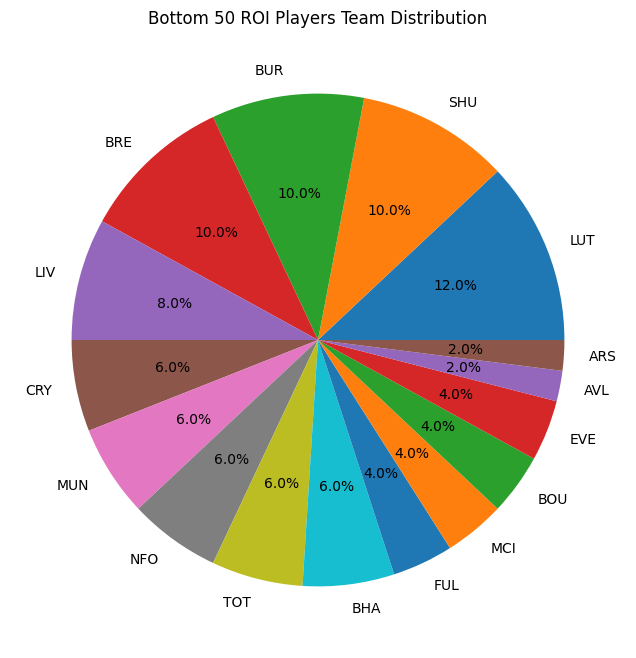

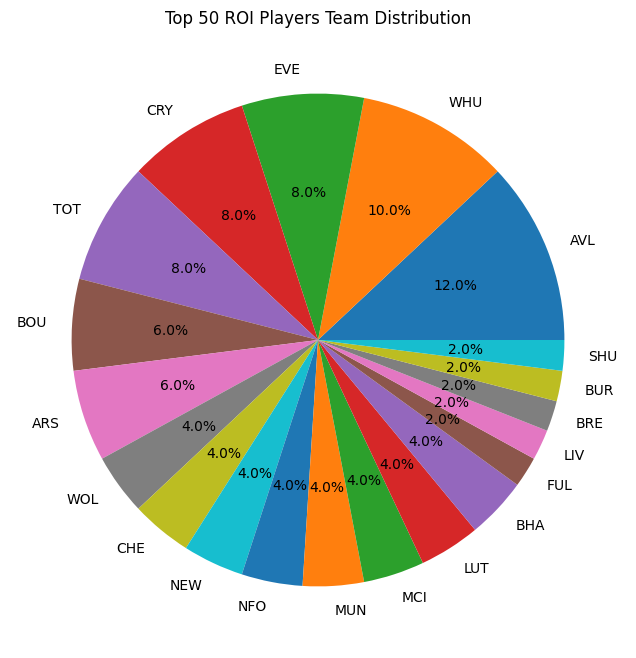

In [11]:
from collections import Counter
import matplotlib.pyplot as plt

#does this process to get team name that each player in the top or bottom 50 is on
top_50_team_position = [string[-6:] for string in top_50_names]
top_50_team = [string[:3] for string in top_50_team_position]

bottom_50_team_position = [string[-6:] for string in bottom_50_names]
bottom_50_team = [string[:3] for string in bottom_50_team_position]

#gets count of each string and how often it appears
top_string_counts = Counter(top_50_team)
bottom_string_counts = Counter(bottom_50_team)

#sorts it in slice size order
top_string_counts = dict(sorted(top_string_counts.items(), key=lambda item: item[1], reverse=True))
bottom_string_counts = dict(sorted(bottom_string_counts.items(), key=lambda item: item[1], reverse=True))

# Extract labels and counts from the Counter
bottom_labels = list(bottom_string_counts.keys())
bottom_counts = list(bottom_string_counts.values())
top_labels = list(top_string_counts.keys())
top_counts = list(top_string_counts.values())

# Create a pie chart
plt.figure(figsize=(8, 8))  # Set the size of the pie chart
plt.pie(bottom_counts, labels=bottom_labels, autopct='%1.1f%%', startangle=0)
plt.title('Bottom 50 ROI Players Team Distribution')
plt.figure(figsize=(8, 8))  # Set the size of the pie chart
plt.pie(top_counts, labels=top_labels, autopct='%1.1f%%', startangle=0)
plt.title('Top 50 ROI Players Team Distribution')

print(top_string_counts)
print(bottom_string_counts)

In [91]:
class Player:
        def __init__(self, name, team, position, status, points, cost):
            self.name = name
            self.team = team
            self.position = position
            self.status = status
            self.points = points
            self.cost = cost

#Cell fills players that would be chosen with important field data for easy access
top_50_players_array = []
top_15_points_players = []

for index in top_50_indices:
    string = data_frame.iloc[index]['Player']
    team_pos = string[-6:]
    name = string[:-6]
    team = team_pos[:3]
    pos = team_pos[-3:]
    points = pd.to_numeric(data_frame.iloc[index]['Points'])
    cost = round(pd.to_numeric(data_frame.iloc[index]['Cost']), 1)
    status_string = data_frame.iloc[index]['Status']

    status = 1
    if status_string[0] != 'V': #if player is injured/suspended/or unlikely to play
        status = 0
        
    top_50_players_array.append(Player(name, team, pos, status, points, cost)) 

for index in top_15_points_indices:
    string = data_frame.iloc[index]['Player']
    team_pos = string[-6:]
    name = string[:-6]
    team = team_pos[:3]
    pos = team_pos[-3:]
    points = pd.to_numeric(data_frame.iloc[index]['Points'])
    cost = round(pd.to_numeric(data_frame.iloc[index]['Cost']), 1)
    status_string = data_frame.iloc[index]['Status']

    status = 1
    if status_string[0] != 'V': #if player is injured/suspended/or unlikely to play
        status = 0
        
    top_15_points_players.append(Player(name, team, pos, status, points, cost))

In [97]:
injured_players = []

for player in top_15_points_players:
    if player.status == 0:
        injured_players.append(player)

for player in top_50_players_array:
    if player.status == 0:
        injured_players.append(player)

for player in injured_players:
    print(player.name)

Salah
Son
Haaland
Hee Chan
Mbeumo
Hee Chan
Onana
Son
A.Doucoure
Zinchenko
Sanchez
Mbeumo
Romero
Trippier
Senesi
Johnstone


In [105]:
budget = 100
star_player_limit = 3
gk = 2
df = 5
md = 5
fwd = 3
best_team = []
positions = {'GKP': gk, 'DEF': df, 'MID': md, 'FWD': fwd}

for player in top_15_points_players:
    if len(best_team) < star_player_limit and player not in injured_players and budget >= player.cost and positions[player.position] > 0:
        best_team.append(player)
        budget -= player.cost
        positions[player.position] = positions[player.position] - 1

for player in top_50_players_array:
    if player not in best_team and budget >= player.cost and player not in injured_players and positions[player.position] > 0:
        best_team.append(player)
        budget -= player.cost
        positions[player.position] = positions[player.position] - 1

In [106]:
best_team_players = []
best_team_total_points = sum([player.points for player in best_team])

for player in best_team:
    best_team_players.append(player.name)

print(best_team_players)
print(best_team_total_points)

['Watkins', 'Bowen', 'Saka', 'Areola', 'Douglas Luiz', 'Palmer', 'Gordon', 'Pickford', 'Tarkowski', 'Cunha', 'Mykolenko', 'Andersen', 'J.Alvarez', 'Pedro Porro', 'Saliba']
1297
